# Predicting market direction

In [1]:
import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix


In [2]:
%matplotlib inline

In [3]:
sns.set(style='darkgrid')

## Get Data

Read JSON files

In [4]:
sent_raw = pd.read_pickle('data/sentiment_df.pickle').rename(columns={'publish_date':'date'})
sent_raw.date = pd.to_datetime(sent_raw.date, utc=True).dt.tz_localize(None)

In [5]:
large_cap_raw = pd.read_json('data/large_cap.json', orient='records')
large_cap_raw.date = pd.to_datetime(large_cap_raw.date)
large_cap_raw['pct_change'] = large_cap_raw.close.pct_change().shift(-1)
large_cap_raw['price_increase'] = (large_cap_raw['pct_change']  > 0).astype('uint8')

In [6]:
small_cap_raw = pd.read_json('data/small_cap.json', orient='records')
small_cap_raw.date = pd.to_datetime(small_cap_raw.date)
small_cap_raw['pct_change'] = small_cap_raw.close.pct_change().shift(-1)
small_cap_raw['price_increase'] = (small_cap_raw['pct_change']  > 0).astype('uint8')

In [7]:
gbpeur_raw =  pd.read_json('data/gbp_eur.json', orient='records')
gbpeur_raw.date = pd.to_datetime(gbpeur_raw.date)
gbpeur_raw['pct_change'] = gbpeur_raw.close.pct_change().shift(-1)
gbpeur_raw['price_increase'] = (gbpeur_raw['pct_change'] > 0).astype('uint8')

In [8]:
gbpusd_raw = pd.read_json('data/gbp_usd.json', orient='records')
gbpusd_raw.date = pd.to_datetime(gbpusd_raw.date)
gbpusd_raw['pct_change'] = gbpusd_raw.close.pct_change().shift(-1)
gbpusd_raw['price_increase'] = (gbpusd_raw['pct_change'] > 0).astype('uint8')

Merge the stock price data with sentiment data

In [9]:
# resample to daily interval for fx data
sent_df = sent_raw.set_index('date')['2016-01-01':].resample('D').mean().fillna(method='bfill')

In [10]:
drop_columns = ['open','high', 'low']

In [11]:
small_cap_df = small_cap_raw.set_index('date')['2016-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['stock', 'volume']
)

In [12]:
large_cap_df = large_cap_raw.set_index('date')['2016-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['stock', 'volume']
)

In [13]:
gbpeur_df = gbpeur_raw.set_index('date')['2016-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['fx_pair']
)

In [14]:
gbpusd_df = gbpusd_raw.set_index('date')['2016-01-01':'2019-08-30'].join(sent_df).drop(
    columns=drop_columns+['fx_pair']
)

## EDA on the Raw Features

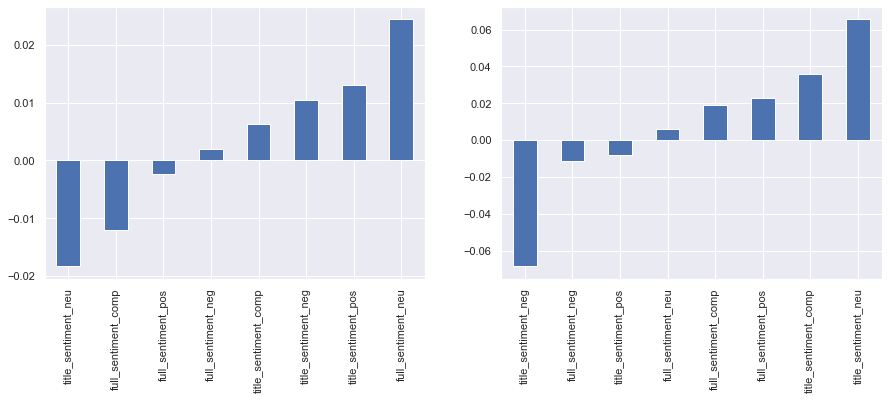

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
large_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[0])
large_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[1])

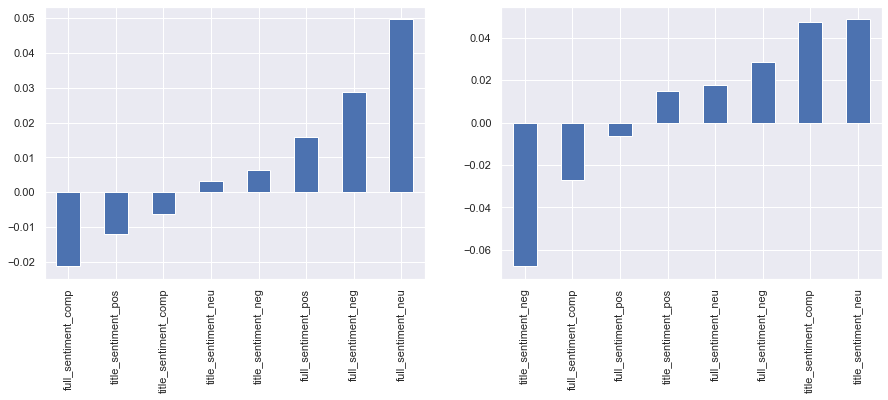

In [16]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
small_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[0])
small_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[1])

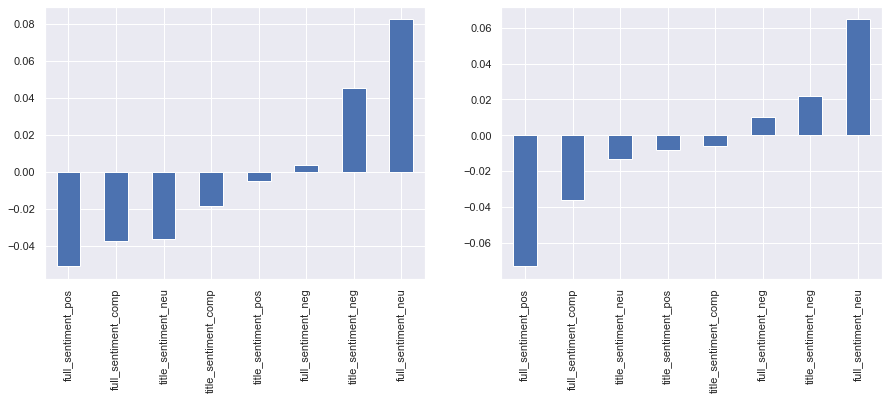

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
gbpeur_df.corr()['pct_change'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[0])
gbpeur_df.corr()['price_increase'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[1])

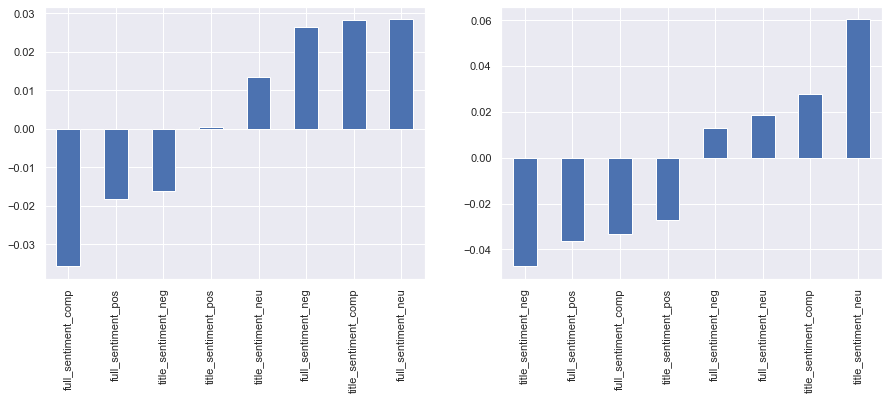

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
gbpusd_df.corr()['pct_change'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[0])
gbpusd_df.corr()['price_increase'].drop(['pct_change', 'price_increase', 'close']).sort_values().plot(kind='bar', ax=ax[1])

## Generate Features with tsfresh

Had to run the run the code using AWS EC2 as my laptop did not the necessary memory. Below is the code i used to generate the features.

```python
import pandas as pd
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features

# Load the data
large_cap_df = pd.read_pickle('large_cap.pickle')
small_cap_df = pd.read_pickle('small_cap.pickle')
gbpeur_df = pd.read_pickle('gbpeur.pickle')
gbpusd_df = pd.read_pickle('gbpusd.pickle')

def create_features(df):
    df['id'] = 1
    X = df.drop(['price_increase', 'pct_change', 'close'], axis=1)
    y = df[['price_increase', 'pct_change']]
    X_roll = roll_time_series(X.reset_index(), column_id='id', rolling_direction=1, column_sort='date', column_kind=None)
    X_fet = extract_features(X_roll,column_id='id', column_sort='date' )
    return X_fet.join(y)

# Generate features and save 
new_large_cap = large_cap_df.pipe(create_features)
new_large_cap.to_pickle('new_large_cap.pickle')

new_small_cap = small_cap_df.pipe(create_features)
new_small_cap.to_pickle('new_small_cap.pickle')

new_gbpeur = gbpeur_df.pipe(create_features)
new_gbpeur.to_pickle('new_gbpeur.pickle')

new_gbpusd = gbpusd_df.pipe(create_features)
new_gbpusd.to_pickle('new_gbpusd.pickle')
```

## EDA on New Features

In [19]:
new_large_cap_df = pd.read_pickle('data/tsfresh/new_large_cap.pickle')
new_small_cap_df = pd.read_pickle('data/tsfresh/new_small_cap.pickle')
new_gbpeur_df = pd.read_pickle('data/tsfresh/new_gbpeur.pickle')
new_gbpusd_df = pd.read_pickle('data/tsfresh/new_gbpusd.pickle')

Number of Potential Features

In [20]:
new_large_cap_df.shape[1] - 1

6049

Deal with missing values

In [21]:
new_large_cap_df.dropna(axis=1, inplace=True)
new_small_cap_df.dropna(axis=1, inplace=True)
new_gbpeur_df.dropna(axis=1, inplace=True)
new_gbpusd_df.dropna(axis=1, inplace=True)

Total Number of Features after removing all features with nulls

In [22]:
new_large_cap_df.shape[1] - 1

1665

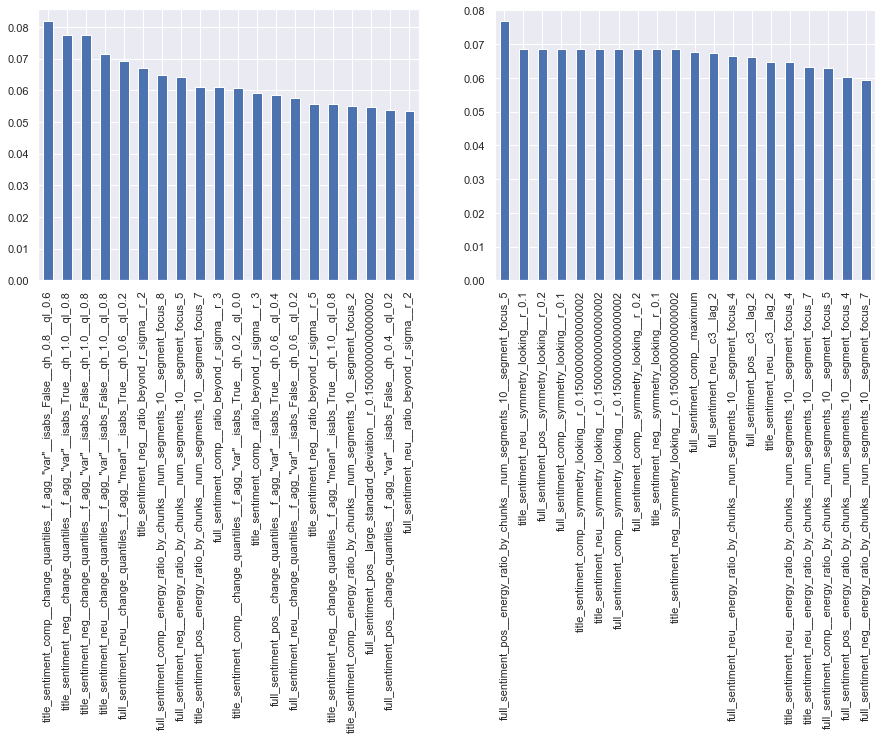

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
new_large_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[0])
new_large_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[1])

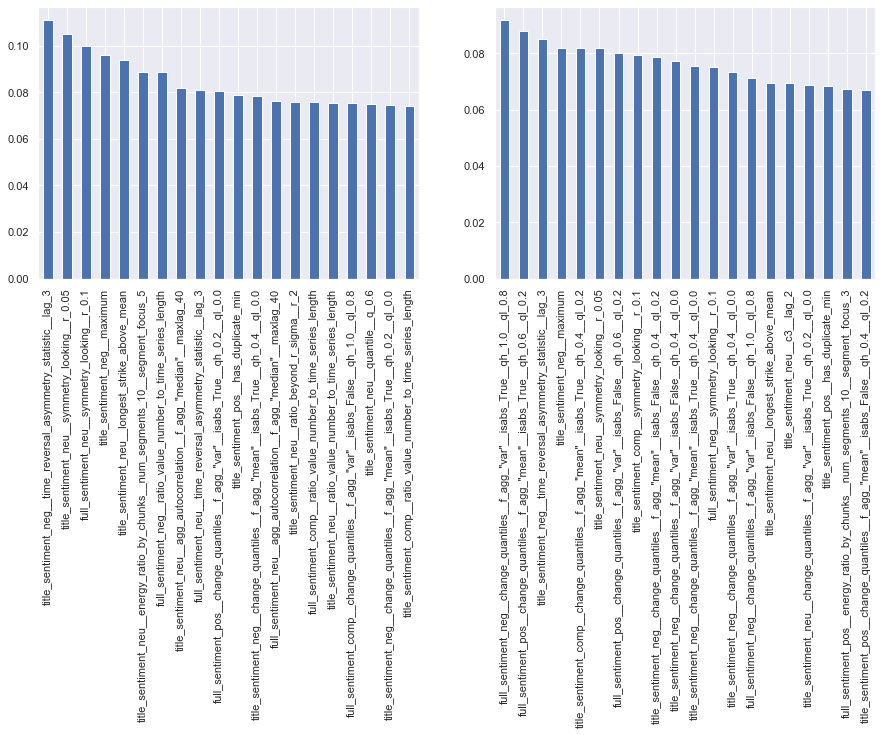

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
new_small_cap_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[0])
new_small_cap_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[1])

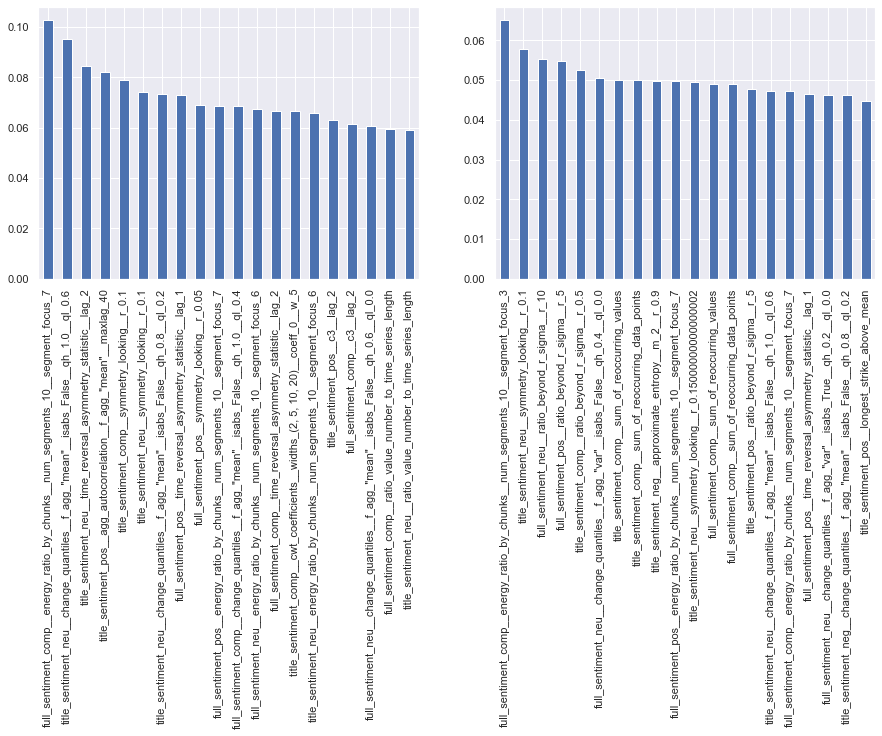

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
new_gbpeur_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[0])
new_gbpeur_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[1])

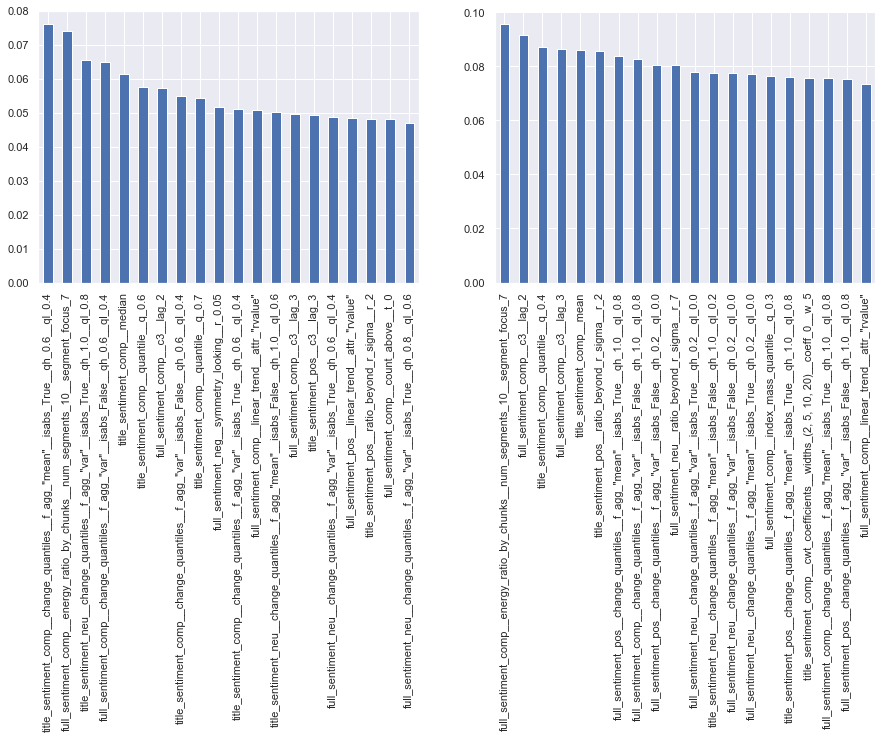

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
new_gbpusd_df.corr()['pct_change'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[0])
new_gbpusd_df.corr()['price_increase'].drop(['pct_change', 'price_increase']).sort_values(ascending=False)[:20].plot(kind='bar', ax=ax[1])

## Base Model

Just by guessing that the price will always increase you get the accuracy below. I will be using this as my base model to provide some context to the performance of the other models built later on

In [27]:
new_small_cap_df.price_increase.value_counts() / len(new_small_cap_df)

0    0.509761
1    0.490239
Name: price_increase, dtype: float64

In [28]:
new_large_cap_df.price_increase.value_counts() / len(new_large_cap_df)

1    0.519523
0    0.480477
Name: price_increase, dtype: float64

In [29]:
new_gbpeur_df.price_increase.value_counts() / len(new_gbpeur_df)

1    0.508268
0    0.491732
Name: price_increase, dtype: float64

In [30]:
new_gbpusd_df.price_increase.value_counts() / len(new_gbpusd_df)

0    0.51778
1    0.48222
Name: price_increase, dtype: float64

## Train and Evaluate Model

Models I tried out are as follows: Logistic Regression, KNN, Random Forest Classifiers, and SVM. I used kfold cross validation and grid search to tune the hyperparameters. All my runs were logged using mlflow and the results are saved in the results folder. Below are the results from each model trying to predict the target for each of the targets.

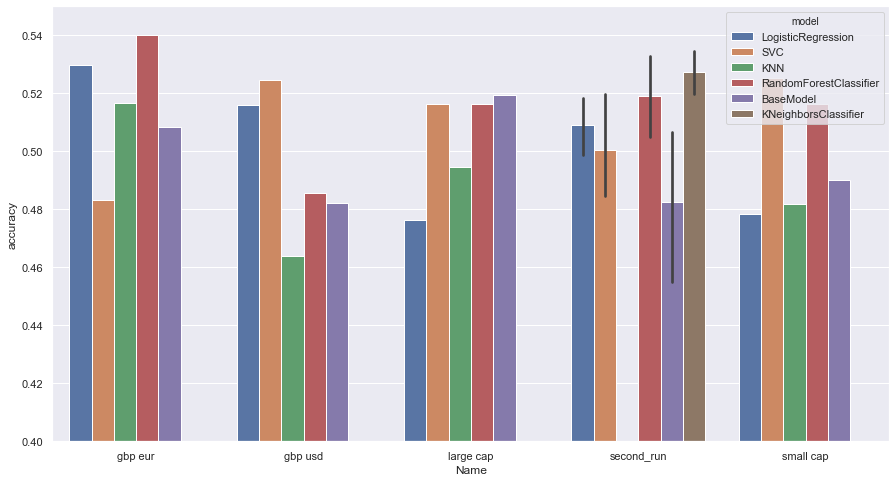

In [31]:
results = glob.glob('results/*.csv')

dfs = []
for result in results:
    temp = pd.read_csv(result)
    temp['Name'] = result.split('\\')[1].split('.')[0]
    dfs.append(temp)
    
result_df = pd.concat(dfs, ignore_index=True, sort=False)

plt.figure(figsize=(15,8))
plt.ylim(0.4, 0.55)
sns.barplot(x='Name', y='accuracy', data=result_df, hue='model')

The results above show that best model we has was trying to predict whether GBP/EUR will increase in price using RandomForestClassifier with parameters below

In [32]:
clf = RandomForestClassifier(
    bootstrap=True, class_weight=None, criterion='gini',
    max_depth=None, max_features='log2', max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, n_estimators=200,
    n_jobs=None, oob_score=False, random_state=None,
    verbose=0, warm_start=False
)

## Test Model

In [33]:
train, test = np.split(new_gbpeur_df, [int(0.8*len(new_gbpeur_df))])

In [34]:
X_train, y_train = train.drop(['pct_change', 'price_increase'], axis=1), train['price_increase']

In [35]:
X_test, y_test = test.drop(['pct_change', 'price_increase'], axis=1), test['price_increase']

In [36]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
y_pred = clf.predict(X_test)

### Classification Report

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.16      0.24       116
           1       0.48      0.77      0.59       114

    accuracy                           0.47       230
   macro avg       0.45      0.47      0.41       230
weighted avg       0.45      0.47      0.41       230



### Confusions Matrix

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(19, 97, 26, 88)

### ROC

In [40]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.49512250453720513

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=1)

Text(0.5, 1.0, 'ROC Curve')

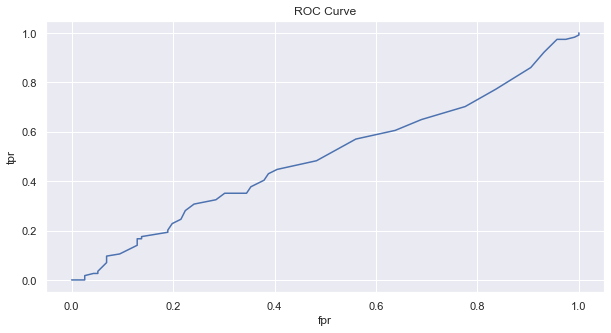

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(fpr, tpr)
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
ax.set_title('ROC Curve')

## Conclusion

Model perfomace is pretty much the same as the base model and hence not much value added. Issue is that the Model predicts too many false positives